## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, though, you'll need to install and run OpenSlide locally.

### Training data

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image

In [2]:
print(np.__version__)

1.15.4


In [3]:
import sklearn
print(sklearn.__version__)

0.20.3


In [4]:
import skimage
print(skimage.__version__)

0.13.0


In [5]:
#Note - numpy <1.16 needed to prevent bug w/skimage
from skimage.color import rgb2gray

In [6]:
from pydrive.auth import GoogleAuth

#gauth = GoogleAuth()
#gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

In [ ]:
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
# Try to load saved client credentials
gauth.LoadCredentialsFile("creds.txt")
if gauth.credentials is None:
    # Authenticate if they're not there
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    # Refresh them if expired
    gauth.Refresh()
else:
    # Initialize the saved creds
    gauth.Authorize()
# Save the current credentials to a file
gauth.SaveCredentialsFile("creds.txt")

drive = GoogleDrive(gauth)

#textfile = drive.CreateFile()
#textfile.SetContentFile('eng.txt')
#textfile.Upload()
#print textfile

#drive.CreateFile({'id':textfile['id']}).GetContentFile('eng-dl.txt')

/usr/local/anaconda/lib/python3.6/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access creds.txt: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))
/usr/local/anaconda/lib/python3.6/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access credentials.json: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=849435679689-4v4s4s0kehgbvdjnj08uq1d7j6kogrbe.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code&approval_prompt=force



In [0]:
import os

MY_DRIVE_DIR = '/content/gdrive/My Drive'
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slides')

print(MY_DRIVE_DIR)
print(os.path.exists(MY_DRIVE_DIR))
print(SLIDES_DIR)
print(os.path.exists(SLIDES_DIR))

/content/gdrive/My Drive
True
/content/gdrive/My Drive/slides
True


In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = os.path.join(SLIDES_DIR, 'tumor_094.tif')
tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_094_mask.tif')

#slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
#mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path
#https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5
#slide_url = 'content/gdrive/My Drive/slides/%s' % slide_path
#mask_url = 'content/gdrive/My Drive/slides/%s' % tumor_mask_path

# Download the whole slide image
#if not os.path.exists(slide_path):
  #!curl -O $slide_url

# Download the tumor mask
#if not os.path.exists(tumor_mask_path):
  #!curl -O $mask_url

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/gdrive/My Drive/slides/tumor_094.tif with width: 118784, height: 100352
Read tumor mask from /content/gdrive/My Drive/slides/tumor_094_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (118784, 100352) downsample factor 1
Level 1, dimensions: (59392, 50176) downsample factor 2
Level 2, dimensions: (29696, 25088) downsample factor 4
Level 3, dimensions: (14848, 12544) downsample factor 8
Level 4, dimensions: (7424, 6272) downsample factor 16
Level 5, dimensions: (3712, 3136) downsample factor 32
Level 6, dimensions: (1856, 1568) downsample factor 64
Level 7, dimensions: (928, 784) downsample factor 128
Level 8, dimensions: (464, 392) downsample factor 256


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

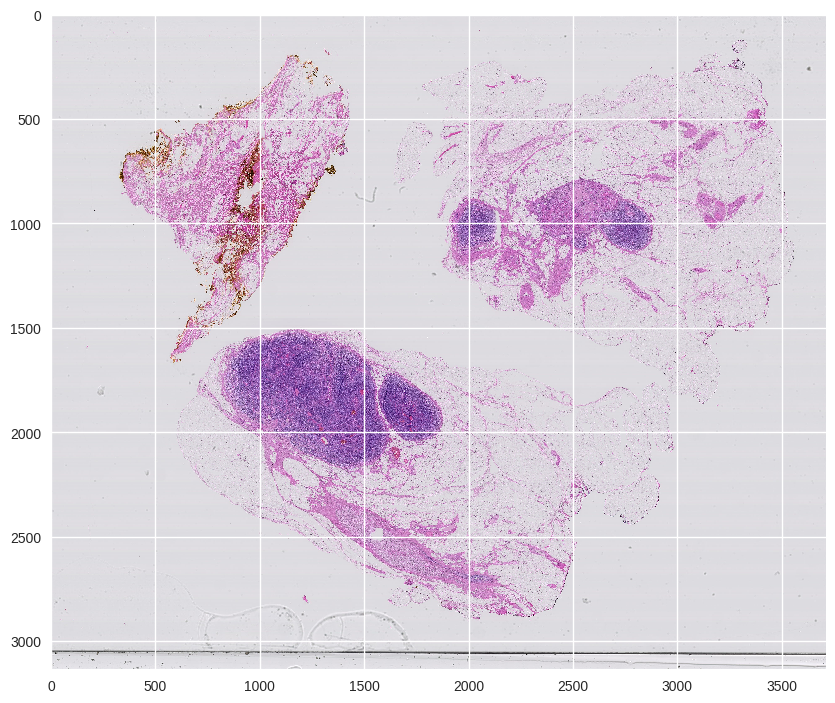

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

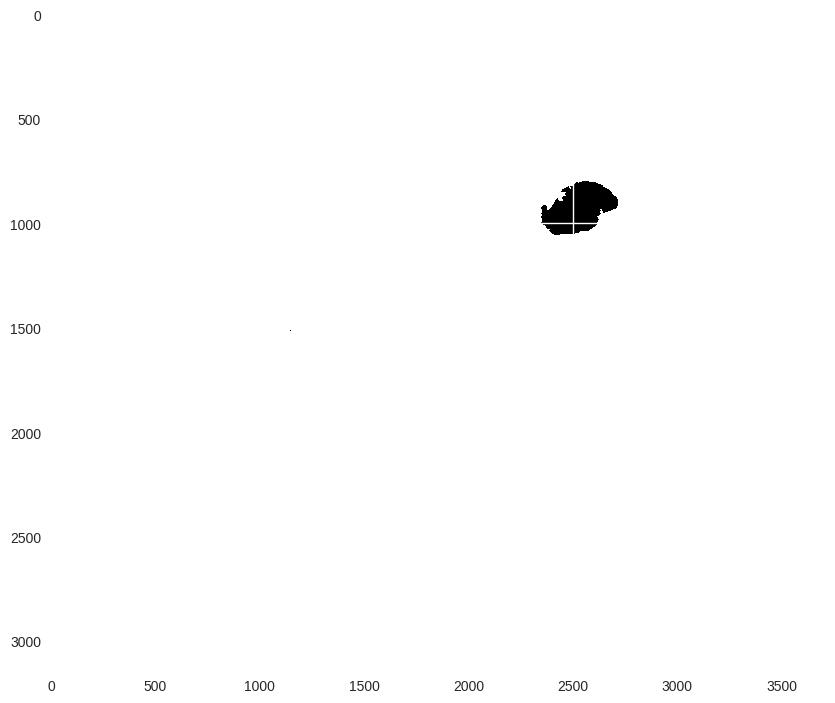

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

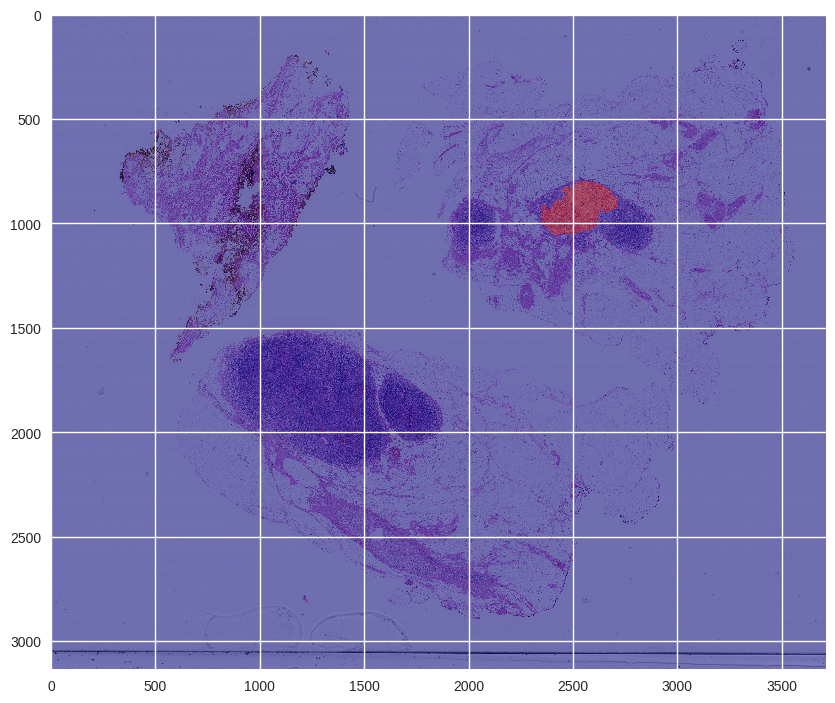

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

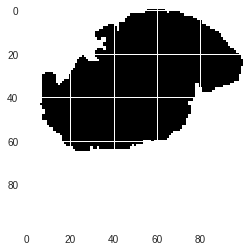

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=580 * 128, y=200 * 128, level=7, width=100, height=100)[:,:,0]
plt.imshow(region)

2215289 tissue_pixels pixels (22.5 percent of the image)


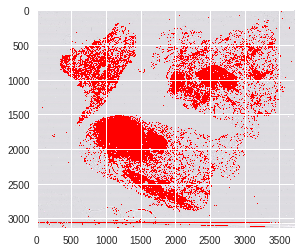

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)